# Le but de ce notebook est de créer notre propre dataset

# Je vais utiliser un modèle pré entraîné, roboflow, pour détecter les vêtements portés par les personnes sur les photos

# J'ai aussi fine-tuné YoloV5 mais l'entraînement demande énormément de ressources

# Importation des packages

In [23]:

%matplotlib inline
import pandas as pd
import numpy as np
from roboflow import Roboflow
import supervision as sv
import cv2
import roboflow
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from collections import Counter
#import torch

# Model
#yolov5 = torch.hub.load('ultralytics/yolov3', 'yolov5l', pretrained=True)


# Connexion à l'API et importation du modèle pré entrainé qui va détecter les vêtements

In [22]:
roboflow.login()
rf = Roboflow()
project = rf.workspace().project("clothes-detection-1kl0o")
fashion = project.version(4).model

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


# Création du dataset de couleur 

In [6]:
### utilisation de nearest neighbors pour associer les couleurs, precisions = nombre couleurs enregistrées

data_color = pd.DataFrame({
    'color': ['Yellow', 'Red', 'Blue', 'Green', 'Orange', 'Brown', 'Black', 'White', 'Pink', 'Purple', 'Grey', 'Beige', 'Beige'],
    'R': [255, 255, 0, 0, 255, 139, 0, 255, 255, 128, 128, 245, 131],
    'G': [255, 0, 0, 255, 165, 69, 0, 255, 192, 0, 128, 245, 110],
    'B': [0, 0, 255, 0, 0, 19, 0, 255, 203, 128, 128, 220, 89]
})

### on ajoute des nuances pour plus de précision
additional_data = pd.DataFrame({
    'color': [       'Yellow', 'Yellow', 'Red', 'Red',         'Blue', 'Blue', 'Green', 'Green',         'Orange', 'Orange', 'Brown', 'Brown',         'Black', 'Black', 'White', 'White',         'Pink', 'Pink', 'Purple', 'Purple',         'Grey', 'Grey', 'Beige', 'Beige', 'Turquoise', 'Turquoise', 'Gold', 'Gold',         'Silver', 'Silver'
    ],
    'R': [        255, 204, 255, 204,         173, 0, 173, 0,         255, 204, 165, 96,         76, 51, 255, 255,         255, 204, 191, 96,         192, 96, 255, 196,         178, 0, 255, 204,         211, 153
    ],
    'G': [        255, 204, 102, 0,         214, 0, 214, 85,         195, 106, 85, 35,         76, 51, 255, 255,         224, 153, 153, 0,         192, 96, 255, 196,         242, 128, 255, 204,         211, 153
    ],
    'B': [        153, 0, 153, 0,         255, 128, 153, 0,         0, 0, 42, 0,         76, 51, 255, 255,         203, 102, 255, 128,         192, 96, 245, 176,         255, 0, 0, 0,         211, 153
    ]
})

# Concaténation avec le DataFrame existant
data_color = pd.concat([data_color, additional_data], ignore_index=True)
data_color

label_color = np.array(data_color['color'])
X = data_color.drop(['color'], axis = 1)
print(X)

      R    G    B
0   255  255    0
1   255    0    0
2     0    0  255
3     0  255    0
4   255  165    0
5   139   69   19
6     0    0    0
7   255  255  255
8   255  192  203
9   128    0  128
10  128  128  128
11  245  245  220
12  131  110   89
13  255  255  153
14  204  204    0
15  255  102  153
16  204    0    0
17  173  214  255
18    0    0  128
19  173  214  153
20    0   85    0
21  255  195    0
22  204  106    0
23  165   85   42
24   96   35    0
25   76   76   76
26   51   51   51
27  255  255  255
28  255  255  255
29  255  224  203
30  204  153  102
31  191  153  255
32   96    0  128
33  192  192  192
34   96   96   96
35  255  255  245
36  196  196  176
37  178  242  255
38    0  128    0
39  255  255    0
40  204  204    0
41  211  211  211
42  153  153  153


# On entraîne notre modèle KNN

In [7]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(algorithm = "brute", metric = "euclidean")
knn = knn.fit(X)

# fonction qui utilise KNN pour renvoyer la couleur la plus proche de celle connue dans le dataset

In [8]:
### on extrait la couleur dominante de l'image
def preprocess_image(image):
    pixels = image.reshape((-1, 3))
    pixels = np.float32(pixels)
    return pixels

def get_dominant_colors(pixels, k=1):
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_

    # Compter la fréquence des étiquettes de cluster
    label_counts = Counter(labels)

    # Trier les clusters par fréquence décroissante
    sorted_clusters = sorted(label_counts.keys(), key=lambda x: label_counts[x], reverse=True)

    # Obtenir les couleurs dominantes à partir des clusters les plus fréquents
    dominant_colors = kmeans.cluster_centers_[sorted_clusters[:k]].astype(int)
    return dominant_colors

def main_color(it, color_label):
    preprocessed_image = preprocess_image(it)
    dominant_colors = get_dominant_colors(preprocessed_image, k=1)[0]
    #print(dominant_colors)
    #see_color(dominant_colors)
    return get_color(dominant_colors, label_color)

def get_color(rgb, label_color):
    
    indices = list(knn.kneighbors([rgb], 1, return_distance = False))
    '''image = [[rgb for _ in range(100)] for _ in range(100)]

    # Afficher l'image
    plt.imshow(image)
    plt.axis('off')  # Masquer les axes
    plt.show()'''
    return label_color[indices[0]][0]

X does not have valid feature names, but NearestNeighbors was fitted with feature names


'Beige'

# Afficher la couleur dominante de manière visuelle

Beige


X does not have valid feature names, but NearestNeighbors was fitted with feature names


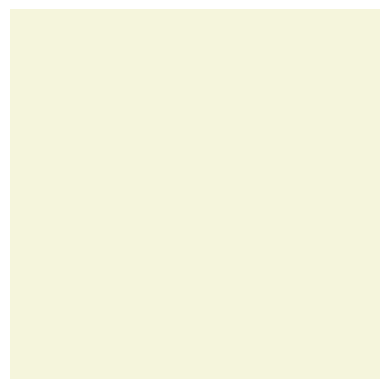

In [11]:
def see_color(rgb):
    color = rgb
    image = [[color for _ in range(100)] for _ in range(100)]

    # Afficher l'image
    plt.imshow(image)
    plt.axis('off')  # Masquer les axes
    plt.show()

print(get_color((245, 245, 220), label_color))
see_color((245, 245, 220))

# Dictionnaire pour distinguer vêtements en bas et en haut

In [12]:
dico_haut = {'shirt', 'jacket', 'polar', 'dress'}
dico_bas = {'jean', 'short', 'skirt', 'pants'}

# On attaque maintenant les fonctions pour extraire les vêtements et la couleur associée

# Dans un premier temps on va extraire les bounding boxes des vêtements détectés, fonction propre à ROBOFLOW

In [13]:
### extraire les objets détectés par le modèle, ici spécifiquement pour le modèle Roboflow
### à modifier si on change de modèle

def extract_boxes_roboflow(model, image, confidence):
    result = model.predict(image, confidence=confidence, overlap=30).json()
    labels = [(item["class"], item['x'], item['y'], item['width'], item['height']) for item in result["predictions"]]
    return labels

## fonction qui renvoie l'image centrée sur le vêtement
def bounding_roboflow(label, image):
        width = label[3]//2
        height = label[4]//2
        x_min = label[1] - width
        y_min = label[2] - height
        x_max = label[1] + width
        y_max = label[2] + height
        it = image[int(y_min) : int(y_max), int(x_min) : int(x_max)]
        return it
    

# Mêmes fonctions mais propres à la prédiction par YOLOV5

In [ ]:
## autres fonctions adaptées pour le modèle YOLOV5

def extract_boxes_yolov5(model, image, confidence):
    dico = {1 : 'shirt', 0 : 'pant'}
    labels = []
    result = model.predict(image)
    descri = np.array(results.xyxy[0])[0]
    detections = results.xyxy[0]  # Résultats au format [x_min, y_min, x_max, y_max, conf, cls]
    for detection in detections:
        x_min, y_min, x_max, y_max, conf, cls = detection.tolist()
        cls = dico[cls]
        labels.append((cls, x_min, y_min, x_max, y_max))
        
    return labels

## fonction qui renvoie l'image centrée sur le vêtement
def bounding_yolov5(label, image):
    x_min, y_min, x_max, y_max = label[1], label[2], label[3], label[4]
    it = image[int(y_min) : int(y_max), int(x_min) : int(x_max)]
    return it
    

# Je définis ensuite la fonction principale qui va extraire les vêtements et leur couleur 

In [16]:

### pour une image, on va extraire les éléments identifiés comme vêtements, vérifier qu'on a un bas et un haut 
## avec la couleur associée

def clothes(image, file, confidence, color_label, type_haut, type_bas, couleur_haut, couleur_bas, name, model):

    aux_haut = []
    aux_bas = []
    aux_couleur_haut = []
    aux_couleur_bas = []
    aux_name = []

    ## détection par le modèle
    
    labels = extract_boxes_roboflow(model, image, confidence)
    ## labels de la forme : list([nom, x, y, largeur, hauteur], ...)
    
    detect_person = False
    
    ## pour chaque label, vêtement haut ou bas, on va prédire le type de vêtement et sa couleur
    for label in labels:
        
        ## on zoom sur le vêtement pour détecter la couleur majoritaire
        it = bounding_roboflow(label, image)

        ## on vérifie si le vêtement est un haut ou un bas et on vérifie également qu'on en détecte qu'un
        if label[0] in dico_haut and len(aux_haut)<1:
            
            ## on enregistre le haut détecté propre à l'image traitée
            aux_haut.append(label[0])
            
            ## on enregistre la couleur du haut détecté propre à l'image traitée
            aux_couleur_haut.append(main_color(it, color_label))
            
            ## s'il s'agit d'une nouvelle image on enregistre son id pour faire le lien plus tard
            if len(aux_name) <1:
                aux_name.append(file)

        if label[0] in dico_bas and len(aux_bas)<1:
            
            ## on enregistre le bas détecté propre à l'image traitée
            aux_bas.append(label[0])
            
            ## on enregistre la couleur du bas détecté propre à l'image traitée
            aux_couleur_bas.append(main_color(it, color_label))
            
            ## s'il s'agit d'une nouvelle image on enregistre son id pour faire le lien plus tard
            if len(aux_name) <1:
                aux_name.append(file)
        
        #### on vérifie qu'aucune personne n'a été détécté avant, pour éviter de mélanger le style de deux
        ### personnes sur l'image
        
        if len(aux_haut)>0 and len(aux_bas)>0 and not detect_person:
            type_haut += aux_haut
            type_bas += aux_bas
            couleur_haut += aux_couleur_haut
            couleur_bas += aux_couleur_bas
            name += aux_name
            
            detect_person = True

            aux_haut = []
            aux_bas = []
            aux_couleur_haut = []
            aux_couleur_bas = []
            aux_name = []
            
    #### si on a pas détecté le haut et le bas on va prendre qu'un vetement et mettre inconnu à l'autre
            
    if not detect_person:
    
    ### si que le bas détecté on met inconnu au haut
        if len(aux_haut)<1 and len(aux_bas)>0:
                aux_haut.append('Inconnu')
                aux_couleur_haut.append('Inconnu')
                if len(aux_name) <1:
                    aux_name.append(file)

    ### si que le haut détecté on met inconnu au bas
        if len(aux_haut)>0 and len(aux_bas)<1:
                aux_bas.append('Inconnu')
                aux_couleur_bas.append('Inconnu')
                if len(aux_name) <1:
                    aux_name.append(file)
                
        type_haut += aux_haut
        type_bas += aux_bas
        couleur_haut += aux_couleur_haut
        couleur_bas += aux_couleur_bas
        name += aux_name

    return type_haut, type_bas, couleur_haut, couleur_bas, name
  #print(type_haut, type_bas, couleur_haut, couleur_bas, name)
  #print(data)
    

# Exemple sur une image

X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


(['jacket'],
 ['pants'],
 ['Beige'],
 ['Black'],
 ['/Users/avicenne/Documents/python/Flask/static/images/Drake1.jpeg'])

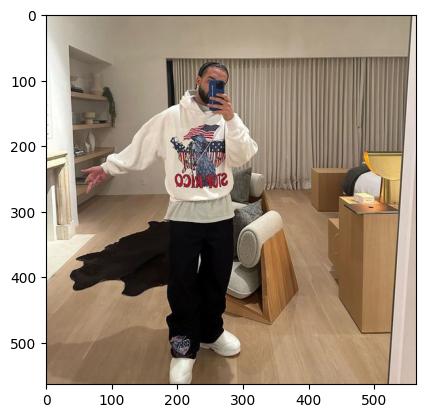

In [19]:
type_haut = []
type_bas = []
couleur_haut = []
couleur_bas = []
name = []


file = "/Users/avicenne/Documents/python/Flask/static/images/Drake1.jpeg"

image = plt.imread(file)
plt.imshow(plt.imread(file))

clothes(image, file, 0.40, label_color, type_haut, type_bas, couleur_haut, couleur_bas, name, fashion)

# Finalement on applique la fonction précédente sur tout le dataset d'image

# on va analyser le dossier qui contient toutes les images et on renvoie le dataset de description

In [20]:
type_haut = []
type_bas = []
couleur_haut = []
couleur_bas = []
name = []


file_path = "/Users/avicenne/Downloads/data"

for file in os.listdir(file_path):
    if file != '.DS_Store':
        image_file = os.path.join(file_path, file)
        image = plt.imread(image_file)
        ### on peut modifier le modèle car à l'avenir on pourra tester avec des modèles plus performants
        type_haut, type_bas, couleur_haut, couleur_bas, name = clothes(image, file, 0.60, label_color, type_haut,
                                                                     type_bas, couleur_haut, couleur_bas, name, fashion)

data = pd.DataFrame({'name' : name, 'type_haut' : type_haut, 'couleur_haut' : couleur_haut, 
                       'type_bas' : type_bas, 'couleur_bas' : couleur_bas})
data

X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature na

,name,type_haut,couleur_haut,type_bas,couleur_bas
0,lil_uzi_vert_outfit13.jpeg,Inconnu,Inconnu,jean,Grey
1,lil_uzi_vert_outfit12.jpeg,jacket,Brown,Inconnu,Inconnu
2,drake_outfit12.jpeg,jacket,Beige,pants,Black
3,lil_uzi_vert_outfit15.jpeg,polar,Grey,Inconnu,Inconnu
4,lil_uzi_vert_outfit112.jpeg,shirt,Silver,pants,Silver
5,drake_outfit111.jpeg,Inconnu,Inconnu,jean,Black
6,lil_uzi_vert_outfit.jpeg,jacket,Grey,Inconnu,Inconnu
7,asap_rocky_outfit8.jpeg,Inconnu,Inconnu,pants,Grey
8,asap_rocky_outfit4.jpeg,Inconnu,Inconnu,skirt,Grey
9,lil_uzi_vert_outfit114.jpeg,jacket,Black,Inconnu,Inconnu


In [87]:
data.to_csv("/Users/avicenne/Downloads/descriptions_images.csv", index = False)

In [88]:
data['couleur_haut'].unique()

array(['Inconnu', 'Brown', 'Beige', 'Grey', 'Silver', 'Black'],
      dtype=object)